In [52]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.signal import stft, resample, welch
from scipy.fft import fft, ifft
from scipy import signal
from copy import deepcopy as dc
from sklearn.preprocessing import LabelEncoder
import mne

FS = 512

In [53]:
data = np.load('../../datasets/avi/multi/data_multi.npy')
label = np.load('../../datasets/avi/multi/labels_multi.npy')

X = data.swapaxes(1, 0)

data.shape, label.shape

((80, 8192), (80,))

In [54]:
w = fft(data)
w.shape

(80, 8192)

In [55]:
def print_graphs(data):
    for i in range(data.shape[0]):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(data.shape[0]):
        plt.psd(data[i,:], Fs=FS)
    plt.title('Domínio da frequência')
    plt.show()
    
    for i in range(data.shape[0]):
        plt.specgram(data[i,:], Fs=FS)
    plt.title('Espectrograma')
    plt.show()

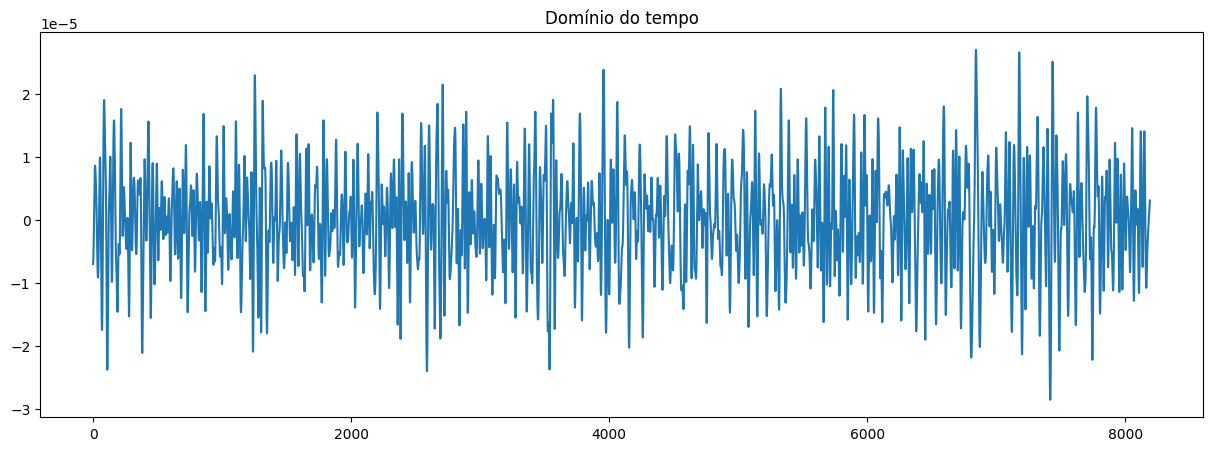

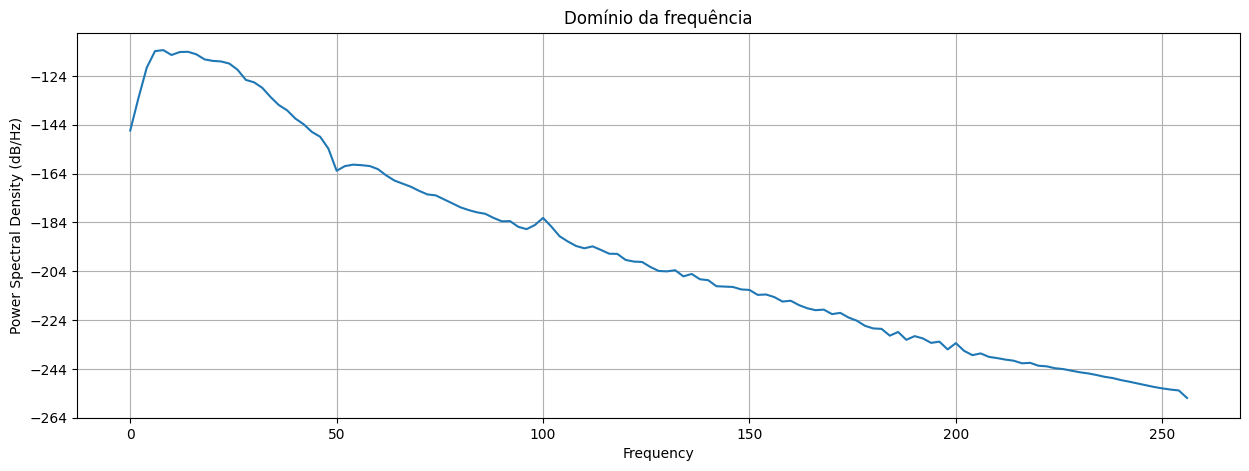

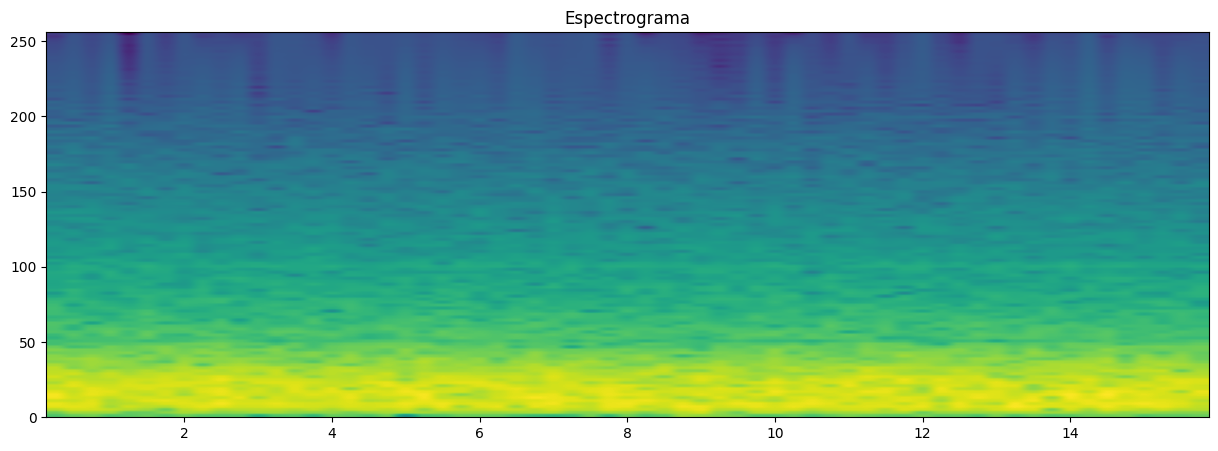

In [56]:
rcParams['figure.figsize'] = [15., 5.]
print_graphs(data[:1,:])

In [57]:
ch = 1
freqSp = FS
ch_name = ['Oz']
ch_type = ['eeg']

info = mne.create_info(ch_name, sfreq=freqSp, ch_types=ch_type)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [58]:
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(label))),
    np.zeros(label.shape[0], dtype=int),
    le.fit_transform(label))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated


Number of events,80
Events,6: 326.5: 47: 87.5: 128.2: 209.3: 4
Time range,0.000 – 15.998 s
Baseline,off


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)

Overwriting existing file.


c:\Python310\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
C:\Users\maran\AppData\Local\Temp\ipykernel_40936\602107904.py:3: RuntimeWarning: This filename (../../datasets/avi/multi/mne_data.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne_data_filtered.save(fname="../../dataset

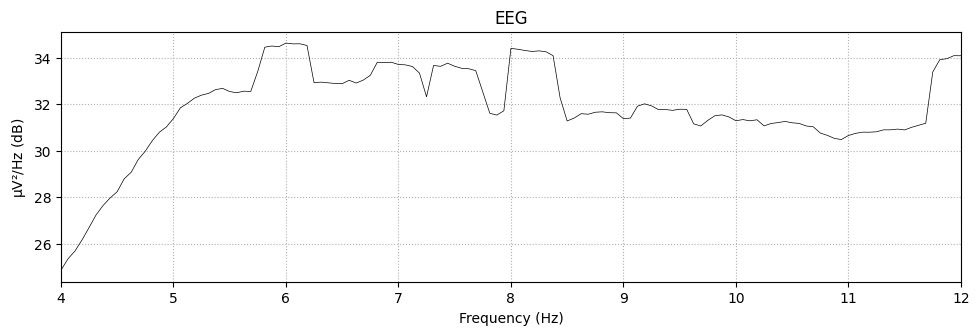

In [59]:
mne_data.plot_psd(fmin=4, fmax=12, average=True, spatial_colors=False)
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)
mne_data_filtered.save(fname="../../datasets/avi/multi/mne_data.fif", overwrite=True)

In [60]:
def butter_bandpass(data, lowcut, highcut, fs=FS, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=FS, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=FS, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=FS, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

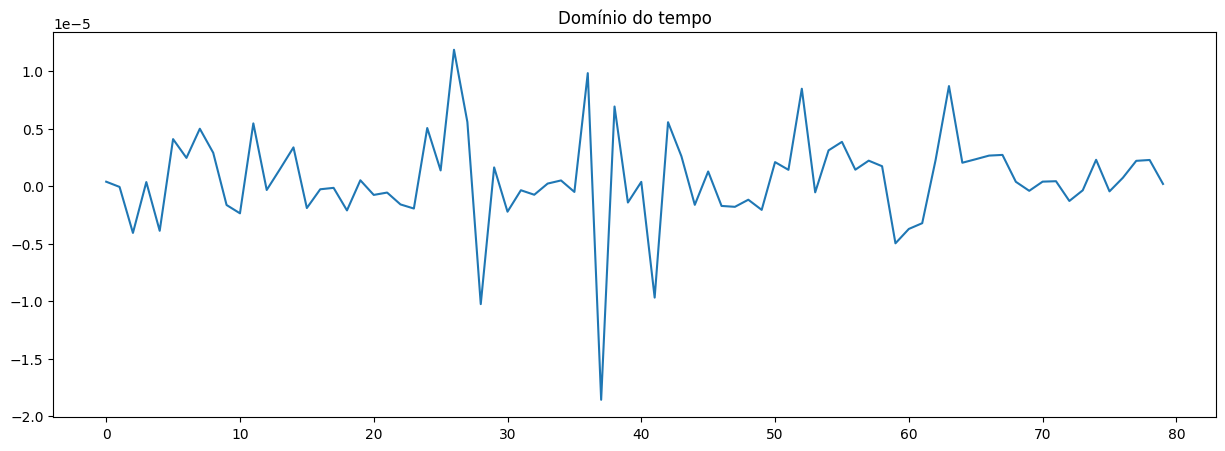

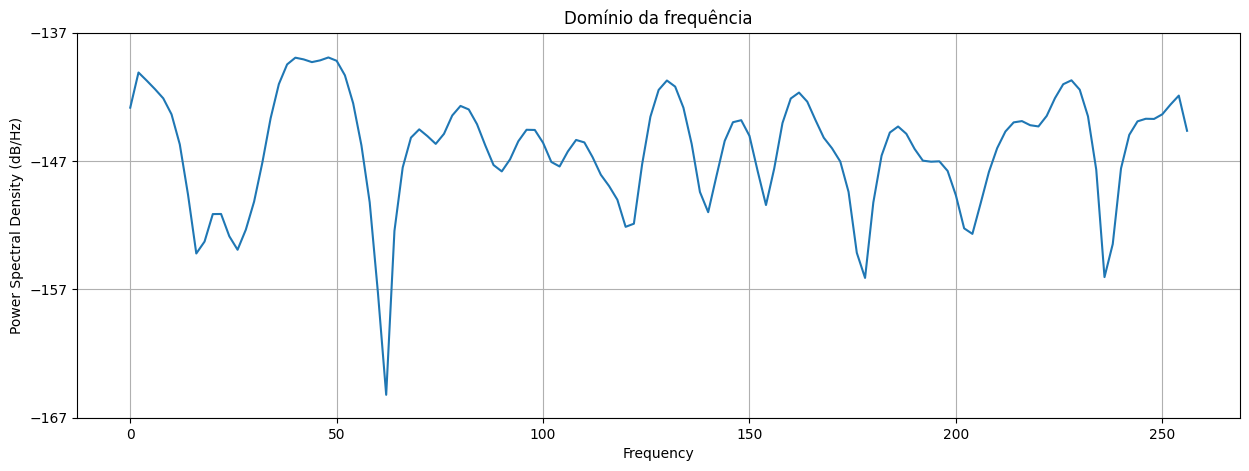

C:\Users\maran\AppData\Local\Temp\ipykernel_40936\4284849796.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=80).
  plt.specgram(data[i,:], Fs=FS)


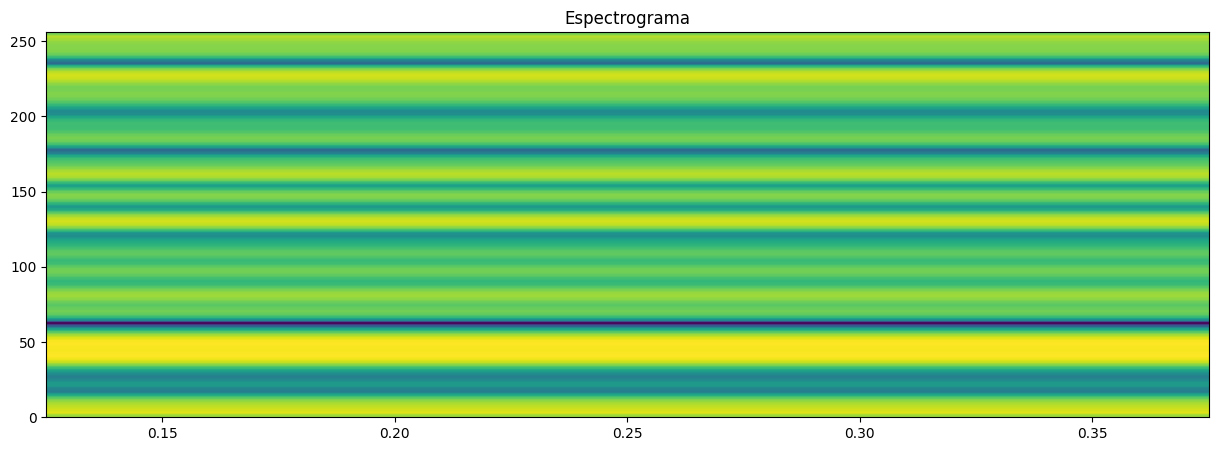

In [61]:
X_f = dc(X)
X_f = butter_notch(X_f, 60)
X_f = butter_notch(X_f, 120)
print_graphs(X_f[:1,:])

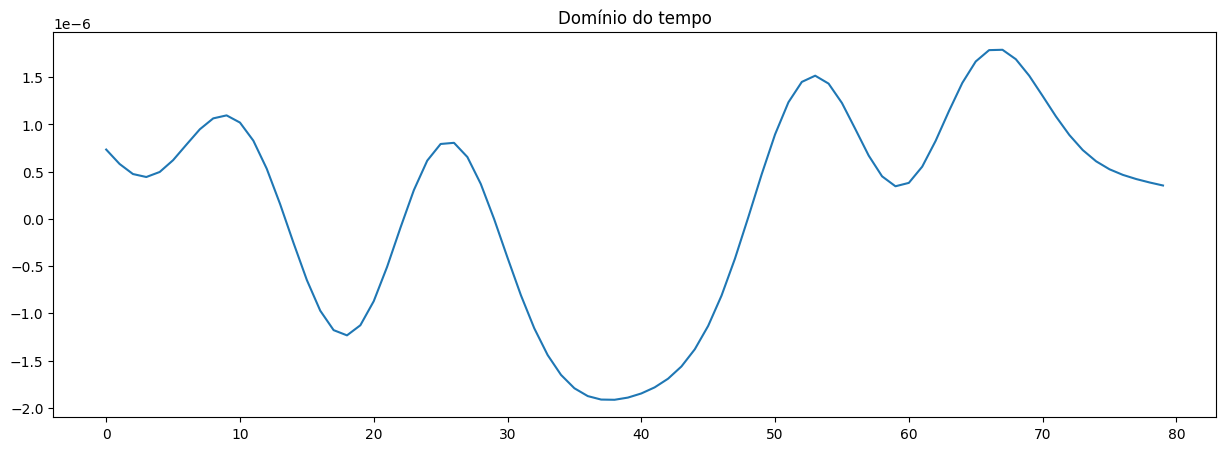

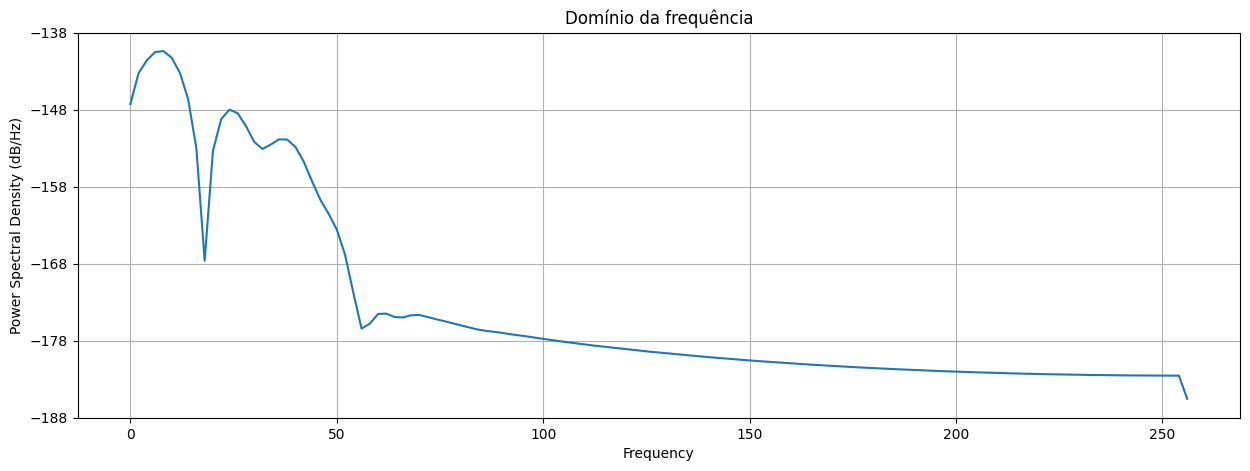

C:\Users\maran\AppData\Local\Temp\ipykernel_40936\4284849796.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=80).
  plt.specgram(data[i,:], Fs=FS)


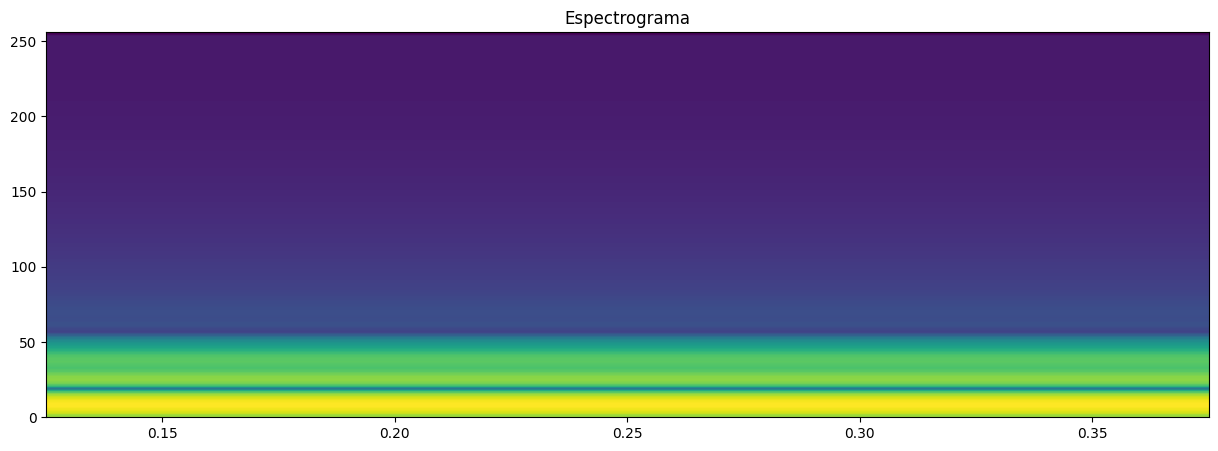

In [62]:
X_f = dc(X)
X_f = butter_bandpass(X_f, 3., 35.)
print_graphs(X_f[:1,:])

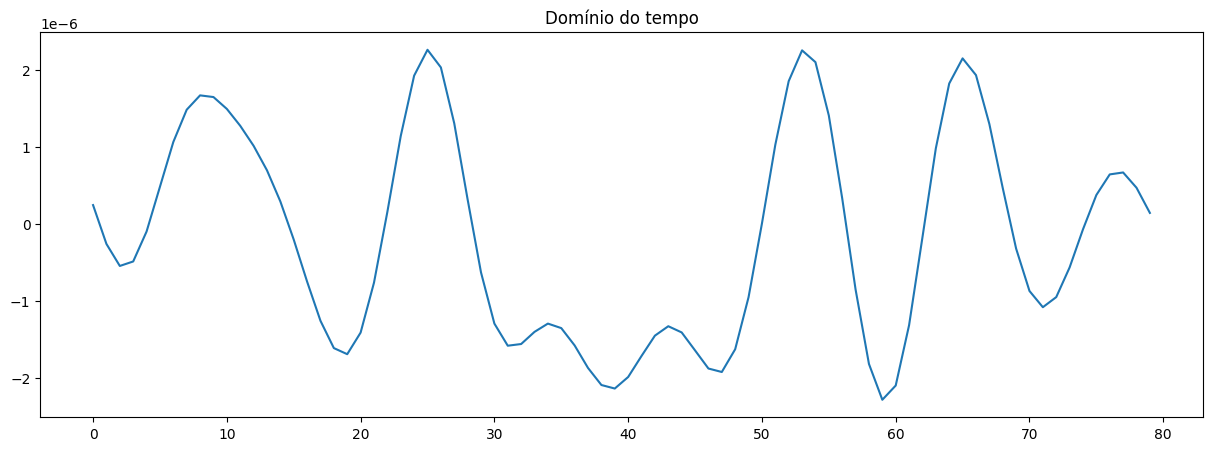

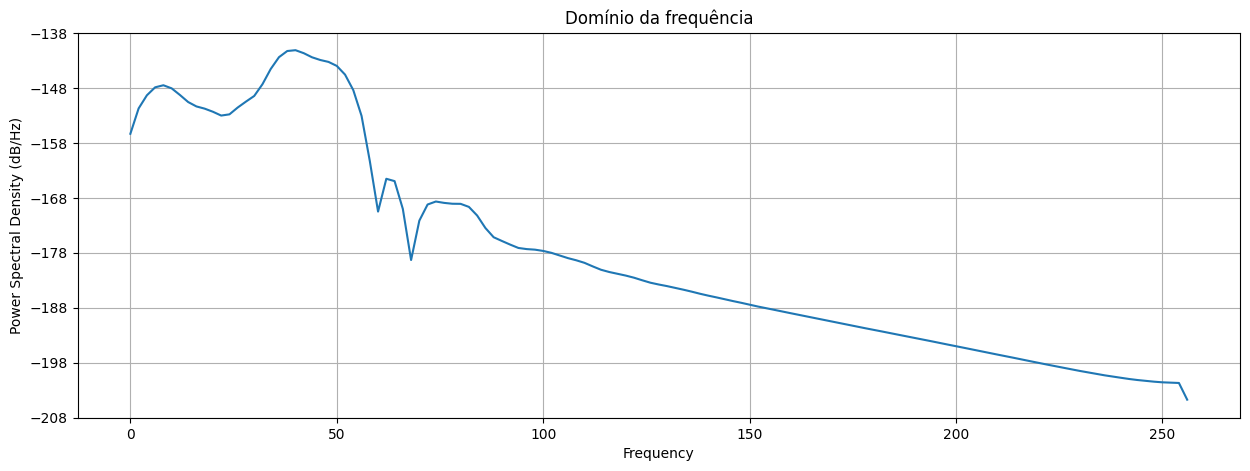

C:\Users\maran\AppData\Local\Temp\ipykernel_40936\4284849796.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=80).
  plt.specgram(data[i,:], Fs=FS)


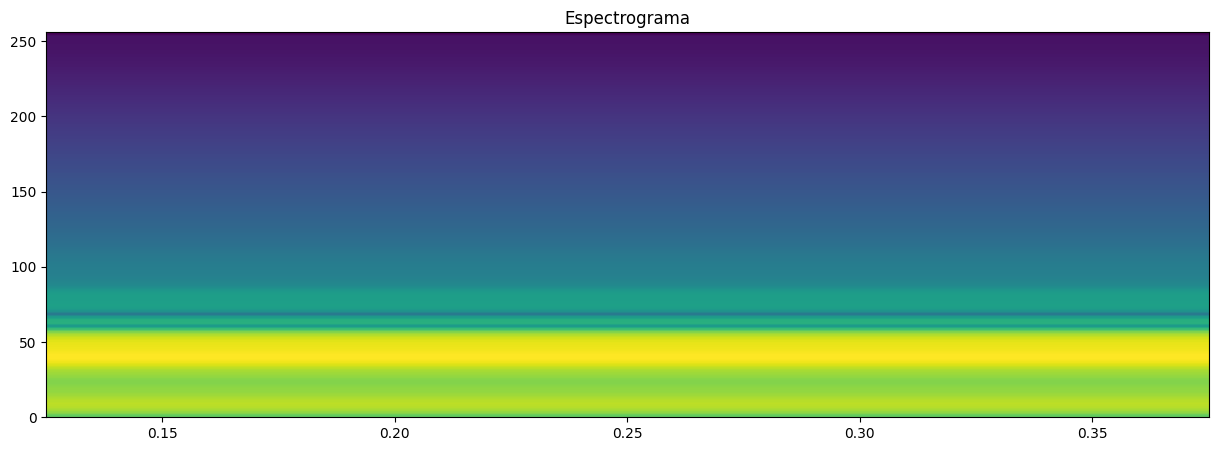

In [63]:
X_f = dc(X)
X_f = butter_notch(X_f, 60)
X_f = butter_notch(X_f, 120)
X_f = butter_lowpass(X_f, 50.)
X_f = butter_highpass(X_f, 3.)
print_graphs(X_f[:1,:])
np.save("../../datasets/OpenBCI_GUI-v5-meditation_filtered.npy", X_f)